In [1]:
from tutorialQA_framework import *
from tutorial1_framework import *

device = torch.device('cuda:0')
device

pygame 2.6.1 (SDL 2.28.4, Python 3.12.7)
Hello from the pygame community. https://www.pygame.org/contribute.html
🔥 text_pretraining_data/eng_sentences_pruned-train.txt
🔥 text_pretraining_data/eng_sentences_pruned-eval.txt


device(type='cuda', index=0)

In [2]:
from visual_transformer import *
from visual_transformer.enhanced_model import *

In [3]:
# now, a few additional imports and functions which can't be saved to a file

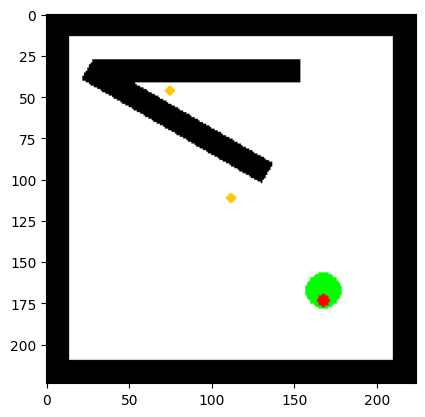

In [4]:
import matplotlib.pyplot as plt
plt.imshow(G.getData())

In [5]:
def quick_display(torch_img):
    clean = torch_img.detach().cpu()
    right_order = torch.permute(clean, (1, 2, 0))
    array = right_order.numpy()
    plt.imshow(array)

In [6]:
# Ok, now let's import the representative old and new brains

In [7]:
old_brain = DefaultAgentBrain()
old_brain.to(device)
old_brain.load_state_dict(torch.load('brain_checkpoints/brain_weights_tutorialQA_v3_batch6100.pth', weights_only=True, map_location=device))

<All keys matched successfully>

In [8]:
brain = EnhancedAgentBrain()
brain.to(device)

brain.load_state_dict(torch.load('brain_checkpoints/enhanced_brain_transferred_weights_tutorialQA.pth', weights_only=True, map_location=device))

<All keys matched successfully>

In [9]:
type(old_brain) is EnhancedAgentBrain

False

In [10]:
# now, without any optimization loop, let's write the code for 1 round of the QA task

In [11]:
import random

num_controls = len(sdt)
def _qa_task_batch(batch_size, model, batch_num=0, random_order = True, model_eval=True, reset_model=True, printing=True):
    if model_eval:
        model.eval()
    
    S = get_settings_batch(batch_size)
    imgs = get_images(S)
    
    texts_lrg = task2_lrgold_generator_simple(S)
    texts_udg = task2_udgold_generator_simple(S)
    texts_lra = task2_lragent_generator_simple(S)
    texts_uda = task2_udagent_generator_simple(S)

    ind = (batch_num * batch_size) % num_controls
    if ind + batch_size > num_controls:
        ind = num_controls - batch_size
    control_texts = sdt[ind:ind + batch_size].to(device)

    all_texts = [control_texts, texts_lrg, texts_udg, texts_lra, texts_uda]
    text_inds = list(range(5))
    # new code. Shuffling helps enhanced brain not transfer information 
    # between tasks, despite not doing any resets
    if random_order:
        random.shuffle(text_inds)

    all_probs = [0 for t_ind in text_inds]
    # first to be computed needs to initialize context buffer
    if type(model) is EnhancedAgentBrain:
        all_probs[text_inds[0]] = (model(all_texts[text_inds[0]], imgs, ret_imgs=False, create_context=True))
    else:
        all_probs[text_inds[0]] = (model(all_texts[text_inds[0]], imgs, ret_imgs=False))
    for t_ind in text_inds[1:]:
        if type(model) is EnhancedAgentBrain:
            all_probs[t_ind] = (model(all_texts[t_ind], imgs, ret_imgs=False, create_context=False))
        else:
            all_probs[t_ind] = (model(all_texts[t_ind], imgs, ret_imgs=False))
    #now, all_probs, despite random execution order, has the corresponding output for every element of all_texts

    all_losses = [get_text_loss(all_probs[i], all_texts[i]) for i in range(5)]
    
    loss = sum(all_losses)

    if printing:
        print(f"Total loss: {loss.item()}:\n{all_losses[0].item()} control,\n{all_losses[1].item()} lrg,\n{all_losses[2].item()} udg,\n{all_losses[3].item()} lra,\n{all_losses[4].item()} uda\n\n")

    if reset_model and (type(model) is EnhancedAgentBrain):
        model.reset()

    return loss # None?

def qa_task_batch(batch_size, model, batch_num=0, compute_grad=False, random_order = True, model_eval=True, reset_model=True, printing=True):
    if compute_grad:
        return _qa_task_batch(batch_size, model, batch_num, random_order, model_eval, reset_model, printing)
    else:
        with torch.no_grad():
            return _qa_task_batch(batch_size, model, batch_num, random_order, model_eval, reset_model, printing)
            

In [12]:
def _arrow_task_batch(batch_size, model, batch_num=0, random_order=True, model_eval=True, reset_model=True, printing=True):
    if model_eval:
        model.eval()

    inp, out, task_texts = task1_img_sample(batch_size)
    ind = (batch_num * batch_size) % num_controls
    if ind + batch_size > num_controls:
        ind = num_controls - batch_size
    control_texts = sdt[ind:ind + batch_size].to(device)

    flip = 0
    if random_order:
        flip += random.randint(0, 1)

    if flip:
        # do not need to set create_context; it's always true here, since we're return images
        task_probs, task_recon = model(task_texts, inp, ret_imgs=True)
        control_probs, control_recon = model(control_texts, inp, ret_imgs=True)
    else:
        control_probs, control_recon = model(control_texts, inp, ret_imgs=True)
        task_probs, task_recon = model(task_texts, inp, ret_imgs=True)

    l1 = img_criterion(task_recon, out)
    l2 = img_criterion(control_recon, inp)
    img_loss = l1 + l2 # may add coefficients later; in retrospect, no need, l1 is always much bigger anyway.
    tl1 = get_text_loss(task_probs, task_texts)
    tl2 = get_text_loss(control_probs, control_texts)
    text_loss = tl1 + tl2
    loss = img_loss + (text_loss / 5000)

    if printing:
        print(f"Total loss: {loss.item()}; that's {l1.item()} task and {l2.item()} recon and {text_loss.item()} total text\n\n")

    if reset_model and (type(model) is EnhancedAgentBrain):
        model.reset()

    return loss

def arrow_task_batch(batch_size, model, batch_num=0, compute_grad=False, random_order=True, model_eval=True, reset_model=True, printing=True):
    if compute_grad:
        return _arrow_task_batch(batch_size, model, batch_num, random_order, model_eval, reset_model, printing)
    else:
        with torch.no_grad():
            return _arrow_task_batch(batch_size, model, batch_num, random_order, model_eval, reset_model, printing)


In [13]:
arrow_task_batch(64, old_brain)

/home/atbolsh/anaconda3/envs/llava-florence/lib/python3.12/site-packages/torch/_tensor.py:955: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Total loss: 0.0024096921551972628; that's 0.001066054217517376 task and 0.0006090174429118633 recon and 3.673102378845215 total text




tensor(0.0024, device='cuda:0')

In [14]:
inp, out, task_texts = task1_img_sample(2)

In [15]:
task_probs, task_recon = old_brain(task_texts, inp, ret_imgs=True)

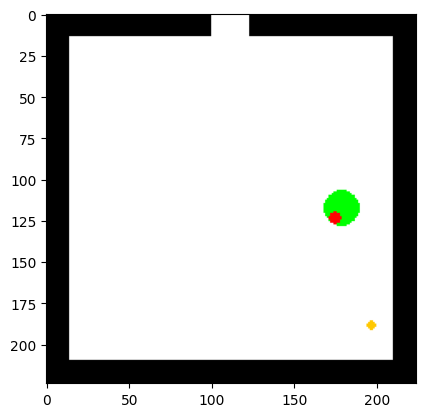

In [16]:
quick_display(inp[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49545124..1.1464659].


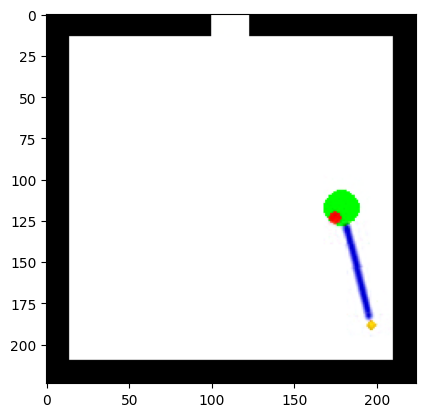

In [17]:
quick_display(task_recon[0])

In [18]:
# ok, good enough for the old brain

In [19]:
arrow_task_batch(64, brain)

Total loss: 2.5382943153381348; that's 1.2615008354187012 task and 1.2730783224105835 recon and 18.575786590576172 total text




tensor(2.5383, device='cuda:0')

In [20]:
qa_task_batch(8, old_brain)

Total loss: 3.7446324825286865:
2.5341482162475586 control,
0.31418389081954956 lrg,
0.32833176851272583 udg,
0.2722221314907074 lra,
0.29574647545814514 uda




tensor(3.7446, device='cuda:0')

In [23]:
brain.reset()
qa_task_batch(8, brain)

Total loss: 46.640846252441406:
9.336299896240234 control,
9.30625057220459 lrg,
9.328795433044434 udg,
9.348119735717773 lra,
9.321381568908691 uda




tensor(46.6408, device='cuda:0')